In [1]:
import numpy as np
from methods.regression_methods import NGGP, get_transforms
from run_regression import *
from training.configs import Config as config
from models import backbone
import torch
from argparse import Namespace
from data.neural_loader import *
from torch import tensor
import gpytorch
import matplotlib.pyplot as plt

/Users/jessegill/Desktop/nggp/nggp_lib/reporting/loggers.py:1: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [2]:
save_path_th = '/Users/jessegill/Desktop/nggp/nggp_lib/save/nggp_rbf_5e3/checkpoints/neural/MLP2_NGGP_model.th'
data = torch.load(save_path_th)
params = Namespace(seed=1, model='MLP2', method='NGGP', dataset='neural', update_batch_size=5, meta_batch_size=5, output_dim=40, multidimensional_amp=False, multidimensional_phase=False, noise='gaussian', kernel_type='rbf', save_dir='./save/nggp_rbf_5e3', num_tasks=1, multi_type=3, method_lr=0.001, feature_extractor_lr=0.001, cnf_lr=0.001, all_lr=0.005, neptune=False, use_conditional=False, context_type='backbone', layer_type='concatsquash', dims='32-32', num_blocks=2, time_length=0.5, train_T=False, add_noise=False, divergence_fn='brute_force', nonlinearity='tanh', solver='dopri5', atol=1e-05, rtol=1e-05, step_size=None, test_solver=None, test_atol=None, test_rtol=None, residual=False, rademacher=False, spectral_norm=False, batch_norm=False, bn_lag=0, l1int=None, l2int=None, dl2int=None, JFrobint=None, JdiagFrobint=None, JoffdiagFrobint=None, start_epoch=0, stop_epoch=100, test=False, n_support=5, n_test_epochs=10, out_of_range=False, device='cuda')

In [3]:
save_path_th = '/Users/jessegill/Desktop/nggp/nggp_lib/save/sines_1e6/checkpoints/sines/MLP2_NGGP_model.th'
params = Namespace(seed=1, model='MLP2', method='NGGP', dataset='sines', update_batch_size=5, meta_batch_size=5, output_dim=40, multidimensional_amp=False, multidimensional_phase=False, noise='gaussian', kernel_type='rbf', save_dir='./save/sines_1e6', num_tasks=1, multi_type=3, method_lr=0.001, feature_extractor_lr=0.001, cnf_lr=0.001, all_lr=1e-06, neptune=False, use_conditional=True, context_type='backbone', layer_type='concatsquash', dims='32-32', num_blocks=2, time_length=0.5, train_T=False, add_noise=False, divergence_fn='brute_force', nonlinearity='tanh', solver='dopri5', atol=1e-05, rtol=1e-05, step_size=None, test_solver=None, test_atol=None, test_rtol=None, residual=False, rademacher=False, spectral_norm=False, batch_norm=False, bn_lag=0, l1int=None, l2int=None, dl2int=None, JFrobint=None, JdiagFrobint=None, JoffdiagFrobint=None, start_epoch=0, stop_epoch=100, test=False, n_support=5, n_test_epochs=10, out_of_range=False, device='cuda')

In [6]:
run = True
setup_seed(params)
config = Config(params)
checkpoint_dir, save_path = setup_checkpoint_dir(params)

results_logger = ResultsLogger(params)


device = 'cpu'
logging.info('Device: {}'.format(device))

bb = setup_backbone(device, params)
nggp_model = setup_model(bb, config, device, params)
optimizer = setup_optimizer(nggp_model, params)

if params.test and run:
    test(nggp_model, params, save_path, results_logger)
elif run:
    train(nggp_model, optimizer, params, save_path, results_logger)
setup_checkpoint_dir(params)
nggp_model.load_checkpoint(save_path_th, device)

./save/sines_1e6/checkpoints/sines/MLP2_NGGP_model.th
[0] - Loss: 1.770  MSE: 3.092 noise: 0.693
[0] - Loss: 2.708  MSE: 5.847 noise: 0.693
[0] - Loss: 1.004  MSE: 0.011 noise: 0.693
[0] - Loss: 1.315  MSE: 1.477 noise: 0.693


/Users/jessegill/Desktop/nggp/nggp_lib/CNF_lib/layers/odefunc.py:350: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).type_as(y)


[0] - Loss: 1.123  MSE: 0.405 noise: 0.693
[10] - Loss: 1.253  MSE: 0.866 noise: 0.693
[10] - Loss: 4.406  MSE: 12.606 noise: 0.693
[10] - Loss: 1.089  MSE: 0.274 noise: 0.693
[10] - Loss: 1.139  MSE: 0.543 noise: 0.693
[10] - Loss: 4.063  MSE: 13.479 noise: 0.693
[20] - Loss: 3.613  MSE: 11.057 noise: 0.693
[20] - Loss: 1.112  MSE: 0.340 noise: 0.693
[20] - Loss: 2.118  MSE: 4.703 noise: 0.693
[20] - Loss: 2.088  MSE: 3.984 noise: 0.693
[20] - Loss: 1.394  MSE: 1.380 noise: 0.693
[30] - Loss: 2.297  MSE: 5.899 noise: 0.693
[30] - Loss: 2.342  MSE: 4.250 noise: 0.693
[30] - Loss: 1.808  MSE: 3.307 noise: 0.693
[30] - Loss: 1.018  MSE: 0.110 noise: 0.693
[30] - Loss: 1.518  MSE: 2.338 noise: 0.693


KeyboardInterrupt: 

In [54]:
neural_loader = NeuralDatasetLoader()
batch = neural_loader.get_batch()
list(zip(batch[0],batch[1]))
neural_loader.generate_datastack()

tensor([  1.7936,   1.8352,   1.8769,  ..., 896.4425, 896.4841, 896.5258])
tensor(1.7936) tensor(-0.1400)
tensor([  1.7936,   1.8352,   1.8769,  ..., 896.4425, 896.4841, 896.5258])
tensor(1.7936) tensor(-0.1400)


array([[ 1.7935729 , -0.14002801],
       [ 1.8352395 , -0.14002801],
       [ 1.8769062 , -0.32254297],
       [ 1.9185729 , -0.3077935 ],
       [ 1.9602395 , -0.39923096],
       [ 2.0019062 , -0.42640144],
       [ 2.043573  , -0.4818999 ],
       [ 2.0852396 , -0.4618802 ],
       [ 2.1269062 , -0.49656352],
       [ 2.168573  , -0.31351885],
       [ 2.2102396 , -0.39052093],
       [ 2.2519062 , -0.34391797],
       [ 2.293573  , -0.28867513],
       [ 2.3352396 , -0.41053542],
       [ 2.3769062 , -0.28867513],
       [ 2.418573  , -0.34391797],
       [ 2.4602396 , -0.34197238],
       [ 2.5019062 , -0.24743582],
       [ 2.543573  , -0.40616432],
       [ 2.5852396 , -0.39904344],
       [ 2.6269062 , -0.36115757],
       [ 2.668573  , -0.39801487],
       [ 2.7102396 , -0.31351885],
       [ 2.7519062 , -0.37796447],
       [ 2.793573  , -0.35846618],
       [ 2.8352396 , -0.37463433],
       [ 2.8769062 , -0.3077935 ],
       [ 2.918573  , -0.3077935 ],
       [ 2.9602396 ,

In [55]:
all_batches = []
all_batch_labels = []
while True:  # or some condition to end the loop
    batch, batch_labels = neural_loader.get_batch()
    if batch is None or batch_labels is None:
        break  # Exit loop if there's no more data



    all_batches.append(batch)
    all_batch_labels.append(batch_labels)

# Now, all_batches and all_batch_labels are lists of tensors, each representing a batch
# Example: iterate through each batch
dataloader = zip(all_batches,all_batch_labels)
print(all_batch_labels)


[tensor([[-0.4450],
        [-0.4575],
        [-0.2247],
        [-0.3078],
        [-0.3135],
        [-0.4880],
        [ 2.0523],
        [-0.2887],
        [-0.4062],
        [-0.3439]]), tensor([[-0.5572],
        [-0.3078],
        [-0.4420],
        [-0.3313],
        [-0.4603],
        [-0.3780],
        [-0.3612],
        [-0.4105],
        [-0.3585],
        [-0.3439]]), tensor([[-0.6088],
        [-0.2247],
        [-0.5030],
        [-0.3780],
        [-0.3078],
        [-0.3992],
        [-0.2474],
        [-0.3486],
        [-0.4167],
        [ 1.4734]]), tensor([[-0.4167],
        [-0.2887],
        [-0.4543],
        [-0.3780],
        [-0.4105],
        [-0.3819],
        [-0.4264],
        [-0.4062],
        [-0.3439],
        [-0.2474]]), tensor([[-0.4105],
        [-0.2887],
        [-0.4818],
        [-0.4139],
        [-0.3262],
        [-0.3944],
        [-0.3944],
        [-0.4420],
        [-0.4139],
        [-0.4139]]), tensor([[-0.4575],
        [-0.2247],
 

In [8]:
sample_fn, _ = get_transforms(nggp_model.cnf, nggp_model.use_conditional)

In [40]:
with open("/Users/jessegill/Desktop/nggp/data/ST260_Day1.pkl", 'rb') as f:
    data = pickle.load(f)

data['time']

array([  1.79357288,   1.83523954,   1.87690621, ..., 896.44249413,
       896.4841608 , 896.52582746])

In [ ]:
test_x = all_batches[0]
test_labels = all_batch_labels[0]

test_x = torch.linspace(0, 15, 3).unsqueeze(0).T

test_x = data['time'][:40]
test_x = torch.tensor(test_x, dtype=torch.float32).unsqueeze(1)  # reshape to (N, 1)

Original shape of test_x: torch.Size([40, 1])
Reshaped test_x: torch.Size([40, 1])
tensor([[-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749],
        [-0.4749]])


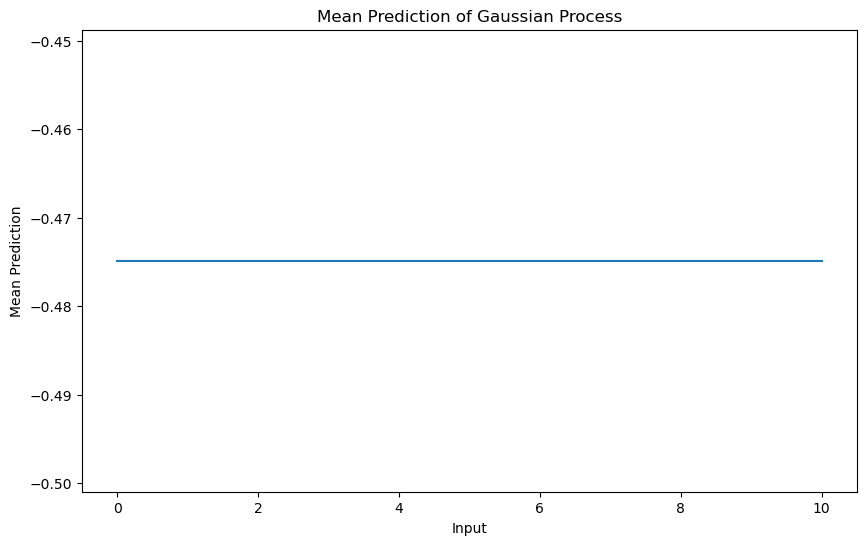

In [74]:
test_x = torch.tensor(np.linspace(0,10,40), dtype=torch.float32).unsqueeze(1)
nggp_model.model.eval()  # Set the model to evaluation mode


print("Original shape of test_x:", test_x.shape)

# If your model expects an input shape of [batch_size, N], reshape test_x accordingly
# For example, if N is 40:
#test_x = test_x.view(-1, 40)  # Reshape to [batch_size, 40]

print("Reshaped test_x:", test_x.shape)

# Continue with the model prediction
z = nggp_model.feature_extractor(test_x)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = nggp_model.model(z)
    means = sample_fn(predictions.mean.unsqueeze(1))


print(means)
# Plot the mean predictions
plt.figure(figsize=(10, 6))
plt.plot(test_x, means)
plt.title("Mean Prediction of Gaussian Process")
plt.xlabel("Input")
plt.ylabel("Mean Prediction")
plt.show()
